In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
gc.collect()
import os
print(os.listdir("../input"))

['2015_BOE_Chiu', '2015_boe_chiu']


In [2]:
input_path = os.path.join('..', 'input', '2015_boe_chiu', '2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [3]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

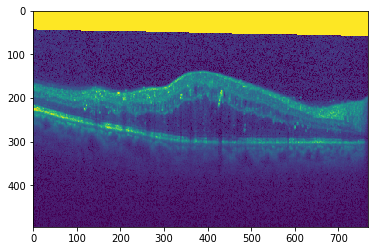

In [4]:
plt.imshow(img_array[25])

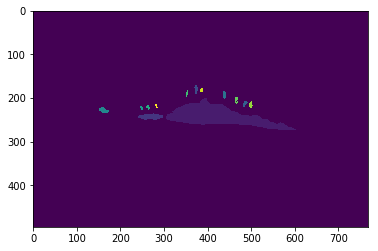

In [5]:
plt.imshow(manual_fluid_array[25])

In [6]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

## Unet

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [9]:
batch_size = 9
epochs = 2500
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [10]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer
        

In [11]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
learning_rate = 1e-4
unet = UNet(in_channel=1,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [13]:
import csv
import os

class CSVLogger:
    def __init__(self, file_name='training_log.csv', fieldnames=['epoch', 'Total loss in epoch', 'val_loss']):
        self.file_name = file_name
        self.fieldnames = fieldnames
        with open(self.file_name, mode='w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writeheader()

    def log(self, info):
        with open(self.file_name, mode='a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow(info)

csv_logger = CSVLogger()

In [14]:
def get_loss(x, y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    if use_gpu:
        x = x.cuda()
        y = y.cuda()
    m = x.shape[0]
    outputs = unet(x)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data  

In [15]:
gc.collect()
print("Starting Training....")
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    unet.train()
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        unet.eval()
        val_loss = get_loss(x_val, y_val)
        csv_logger.log({'epoch': _, 'Total loss in epoch' : total_loss / epoch_iter, 'val_loss': val_loss})
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|          | 0/2500 [00:00<?, ?it/s]

Starting Training....


/opt/conda/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
  2%|▏         | 50/2500 [02:35<2:11:30,  3.22s/it]

Total loss in epoch 50 : 0.6014019250869751 and validation loss : 0.6840017437934875


  4%|▍         | 100/2500 [05:11<2:08:44,  3.22s/it]

Total loss in epoch 100 : 0.5799148082733154 and validation loss : 0.7379918098449707


  6%|▌         | 150/2500 [07:46<2:06:01,  3.22s/it]

Total loss in epoch 150 : 0.5726142525672913 and validation loss : 0.6596296429634094


  8%|▊         | 200/2500 [10:21<2:03:20,  3.22s/it]

Total loss in epoch 200 : 0.5539228916168213 and validation loss : 0.7158675789833069


 10%|█         | 250/2500 [12:56<2:00:38,  3.22s/it]

Total loss in epoch 250 : 0.5416079163551331 and validation loss : 0.724709153175354


 12%|█▏        | 300/2500 [15:32<1:57:57,  3.22s/it]

Total loss in epoch 300 : 0.5290787816047668 and validation loss : 0.7469318509101868


 14%|█▍        | 350/2500 [18:07<1:55:16,  3.22s/it]

Total loss in epoch 350 : 0.5180677771568298 and validation loss : 0.7431418299674988


 16%|█▌        | 400/2500 [20:42<1:52:34,  3.22s/it]

Total loss in epoch 400 : 0.6021887063980103 and validation loss : 0.5566322207450867


 18%|█▊        | 450/2500 [23:17<1:49:54,  3.22s/it]

Total loss in epoch 450 : 0.502335250377655 and validation loss : 0.6572796702384949


 20%|██        | 500/2500 [25:52<1:47:13,  3.22s/it]

Total loss in epoch 500 : 0.49066397547721863 and validation loss : 0.6483592391014099


 22%|██▏       | 550/2500 [28:28<1:44:32,  3.22s/it]

Total loss in epoch 550 : 0.48144015669822693 and validation loss : 0.6785646080970764


 24%|██▍       | 600/2500 [31:03<1:41:52,  3.22s/it]

Total loss in epoch 600 : 0.4724175035953522 and validation loss : 0.7279831171035767


 26%|██▌       | 650/2500 [33:38<1:39:10,  3.22s/it]

Total loss in epoch 650 : 0.46410614252090454 and validation loss : 0.7354713082313538


 28%|██▊       | 700/2500 [36:13<1:36:29,  3.22s/it]

Total loss in epoch 700 : 0.4563969075679779 and validation loss : 0.8022531867027283


 30%|███       | 750/2500 [38:48<1:33:49,  3.22s/it]

Total loss in epoch 750 : 0.4487033784389496 and validation loss : 0.850807249546051


 32%|███▏      | 800/2500 [41:24<1:31:08,  3.22s/it]

Total loss in epoch 800 : 0.44145095348358154 and validation loss : 0.837849497795105


 34%|███▍      | 850/2500 [43:59<1:28:26,  3.22s/it]

Total loss in epoch 850 : 0.536001980304718 and validation loss : 0.3126547932624817


 36%|███▌      | 900/2500 [46:34<1:25:45,  3.22s/it]

Total loss in epoch 900 : 0.43801552057266235 and validation loss : 0.4330112040042877


 38%|███▊      | 950/2500 [49:09<1:23:04,  3.22s/it]

Total loss in epoch 950 : 0.4285304546356201 and validation loss : 0.4388720989227295


 40%|████      | 1000/2500 [51:44<1:20:23,  3.22s/it]

Total loss in epoch 1000 : 0.4208741784095764 and validation loss : 0.46856889128685


 42%|████▏     | 1050/2500 [54:19<1:17:42,  3.22s/it]

Total loss in epoch 1050 : 0.41311582922935486 and validation loss : 0.4916127026081085


 44%|████▍     | 1100/2500 [56:55<1:15:01,  3.22s/it]

Total loss in epoch 1100 : 0.4135771691799164 and validation loss : 0.594339907169342


 46%|████▌     | 1150/2500 [59:30<1:12:20,  3.22s/it]

Total loss in epoch 1150 : 0.4034143090248108 and validation loss : 0.5861778855323792


 48%|████▊     | 1200/2500 [1:02:05<1:09:41,  3.22s/it]

Total loss in epoch 1200 : 0.39782828092575073 and validation loss : 0.560330331325531


 50%|█████     | 1250/2500 [1:04:40<1:06:59,  3.22s/it]

Total loss in epoch 1250 : 0.39248350262641907 and validation loss : 0.5558162927627563


 52%|█████▏    | 1300/2500 [1:07:15<1:04:18,  3.22s/it]

Total loss in epoch 1300 : 0.3873535096645355 and validation loss : 0.5448868274688721


 54%|█████▍    | 1350/2500 [1:09:50<1:01:37,  3.22s/it]

Total loss in epoch 1350 : 0.38236215710639954 and validation loss : 0.5356220602989197


 56%|█████▌    | 1400/2500 [1:12:25<58:55,  3.21s/it]

Total loss in epoch 1400 : 0.39016246795654297 and validation loss : 0.5426900386810303


 58%|█████▊    | 1450/2500 [1:15:01<56:16,  3.22s/it]

Total loss in epoch 1450 : 0.3778572678565979 and validation loss : 0.5421945452690125


 60%|██████    | 1500/2500 [1:17:36<53:35,  3.22s/it]

Total loss in epoch 1500 : 0.37172678112983704 and validation loss : 0.5331390500068665


 62%|██████▏   | 1550/2500 [1:20:11<50:54,  3.22s/it]

Total loss in epoch 1550 : 0.36707666516304016 and validation loss : 0.5285942554473877


 64%|██████▍   | 1600/2500 [1:22:46<48:13,  3.22s/it]

Total loss in epoch 1600 : 0.36275482177734375 and validation loss : 0.5195254683494568


 66%|██████▌   | 1650/2500 [1:25:21<45:32,  3.21s/it]

Total loss in epoch 1650 : 0.35868802666664124 and validation loss : 0.484588086605072


 68%|██████▊   | 1700/2500 [1:27:56<42:53,  3.22s/it]

Total loss in epoch 1700 : 0.37390679121017456 and validation loss : 1.2635383605957031


 70%|███████   | 1750/2500 [1:30:31<40:11,  3.22s/it]

Total loss in epoch 1750 : 0.36398380994796753 and validation loss : 1.424912929534912


 72%|███████▏  | 1800/2500 [1:33:06<37:30,  3.21s/it]

Total loss in epoch 1800 : 0.3505823016166687 and validation loss : 1.046168327331543


 74%|███████▍  | 1850/2500 [1:35:42<34:50,  3.22s/it]

Total loss in epoch 1850 : 0.3468068540096283 and validation loss : 0.9617900848388672


 76%|███████▌  | 1900/2500 [1:38:17<32:09,  3.22s/it]

Total loss in epoch 1900 : 0.3429628610610962 and validation loss : 0.953901469707489


 78%|███████▊  | 1950/2500 [1:40:52<29:28,  3.22s/it]

Total loss in epoch 1950 : 0.33955129981040955 and validation loss : 0.8932098746299744


 80%|████████  | 2000/2500 [1:43:27<26:47,  3.22s/it]

Total loss in epoch 2000 : 0.3364081382751465 and validation loss : 0.8077510595321655


 82%|████████▏ | 2050/2500 [1:46:02<24:06,  3.22s/it]

Total loss in epoch 2050 : 0.3327684700489044 and validation loss : 0.7529519200325012


 84%|████████▍ | 2100/2500 [1:48:37<21:26,  3.22s/it]

Total loss in epoch 2100 : 0.3417477011680603 and validation loss : 0.7046270966529846


 86%|████████▌ | 2150/2500 [1:51:12<18:45,  3.21s/it]

Total loss in epoch 2150 : 0.33670079708099365 and validation loss : 1.302224040031433


 88%|████████▊ | 2200/2500 [1:53:47<16:04,  3.22s/it]

Total loss in epoch 2200 : 0.32885244488716125 and validation loss : 1.237568974494934


 90%|█████████ | 2250/2500 [1:56:23<13:23,  3.21s/it]

Total loss in epoch 2250 : 0.32560378313064575 and validation loss : 1.1470298767089844


 92%|█████████▏| 2300/2500 [1:58:58<10:42,  3.21s/it]

Total loss in epoch 2300 : 0.3221956193447113 and validation loss : 1.0344229936599731


 94%|█████████▍| 2350/2500 [2:01:33<08:02,  3.22s/it]

Total loss in epoch 2350 : 0.37110525369644165 and validation loss : 0.507543683052063


 96%|█████████▌| 2400/2500 [2:04:08<05:21,  3.22s/it]

Total loss in epoch 2400 : 0.31996408104896545 and validation loss : 1.5002634525299072


 98%|█████████▊| 2450/2500 [2:06:43<02:40,  3.22s/it]

Total loss in epoch 2450 : 0.3160691559314728 and validation loss : 1.6356703042984009


100%|██████████| 2500/2500 [2:09:18<00:00,  3.22s/it]

Total loss in epoch 2500 : 0.31321728229522705 and validation loss : 1.6484235525131226


In [16]:
gc.collect()

0

In [17]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

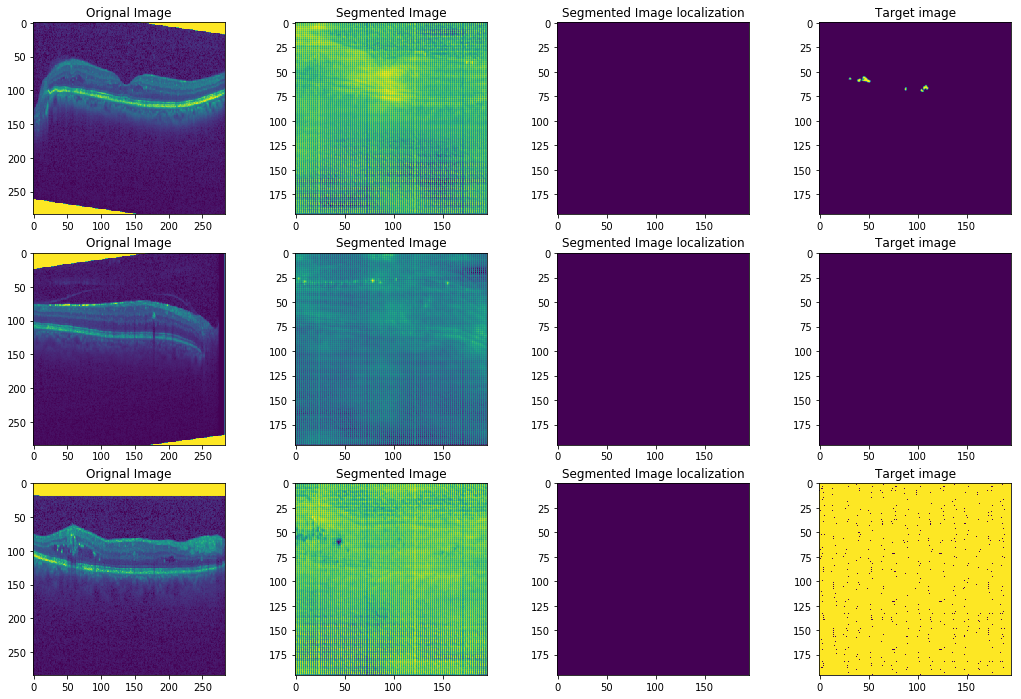

In [18]:
plot_examples(x_train, y_train)

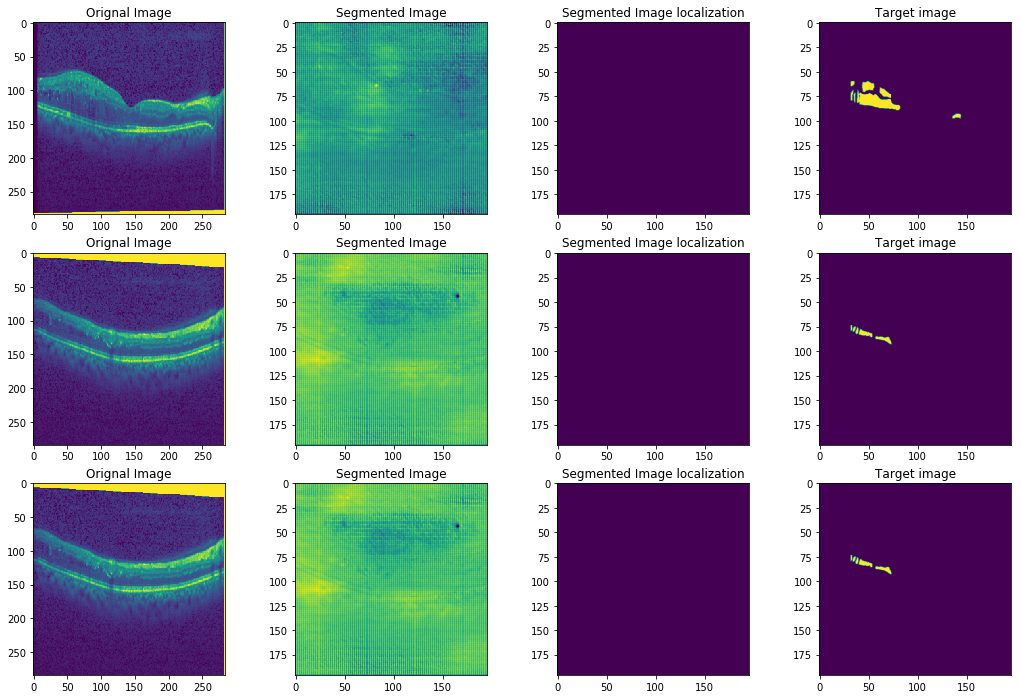

In [19]:
plot_examples(x_val, y_val)

In [20]:
torch.save(unet.state_dict(), 'unet.pt')